In [6]:
import math

import numpy as np

from agent_cnn import DQNAgentCNN
from gameserver import GameServer
from plotter import Plotter

import torch
import torch.nn.functional as F

In [8]:
async def get_score(server, state, is_white):
    score = await server.get_score(state)
    value = 1 if score["black"] > score["white"] else -1
    value *= -1 if is_white else 1
    return value


def is_duplicate_state(state: list[str], history: list[list[str]]):
    history_set = set(history)
    assert len(history) == len(history_set)
    history_size = len(history_set)
    history_set.add(state)

    return len(history_set) == history_size


def get_history(node: "Node", history: list[list[str]]) -> list[list[str]]:
    history.insert(0, node.state)
    if node.parent:
        return get_history(node.parent, history)
    return history


async def has_game_ended(
    server: GameServer,
    state: list[str],
    action: str | tuple[int, int],
    node: "Node",
    is_white: bool,
) -> tuple[bool, float]:
    # both pass back-to-back
    if node.parent and action == "pass" and node.parent.action == "pass":
        return (True, await get_score(server, state, is_white))

    # one pass, next player has no valid moves
    valid_moves = np.sum(await server.request_valid_moves(is_white, state)[:-1])

    x, y = action
    state_after_move = await server.get_state_after_move(x, y, state, is_white)
    history = get_history(node, await server.get_game_history())
    move_creates_duplicate_state = is_duplicate_state(state_after_move, history)

    if (
        node.parent
        and node.parent.action == "pass"
        and (valid_moves == 0 or move_creates_duplicate_state)
    ):
        return (True, await get_score(server, state, is_white))

    # board full
    space_available = any([True for row in state if "." in row])
    if not space_available:
        return (True, await get_score(server, state, is_white))

    return (False, 0)

In [7]:
class Node:
    def __init__(
        self,
        state: list[str],
        server: GameServer,
        is_white: bool,
        agent: DQNAgentCNN,
        parent: "Node" = None,
        action: int = None,
    ):
        self.state = state
        self.parent = parent
        self.action = action
        self.server = server
        self.is_white = is_white
        self.agent = agent

        self.children: list[Node] = []
        self.expandable_to = []

        self.visit_cnt = 0
        self.win_cnt = 0

    async def is_leaf(self) -> bool:
        return int(
            np.sum(await self.server.request_valid_moves(self.is_white, self.state))
        ) == len(self.children)

    def get_ucb_value(
        self,
        num_wins: int,
        num_visited: int,
        parent_visit_cnt: int,
        exploration=math.sqrt(2),
    ) -> float:
        # negative since the child is the opponent player -> node wants child to lose
        return (num_wins / num_visited) + exploration * math.sqrt(
            math.log(parent_visit_cnt) / num_visited
        )

    def next(self) -> "Node":
        best = (None, 0)
        for c in self.children:
            score = self.get_ucb_value(c.win_cnt, c.visit_cnt, self.visit_cnt)
            if score > best[1]:
                best = (c, score)

        return best[0]

    async def expand(self, state, server: GameServer) -> "Node":
        action = self.agent.select_action_eval(
            state,
            await self.server.request_valid_moves(self.is_white, state),
            # [self.parent.state, self.parent.parent.state],
            get_history(self, await self.server.get_game_history()),
            self.is_white,
        )
        x, y = self.agent.decode_action(action)
        next_state = await self.server.get_state_after_move(x, y, state, self.is_white)

        child = Node(
            next_state, server, not self.is_white, self.agent, self.parent, action
        )
        self.children.append(child)
        return child

    async def simulate(self):
        done, score = has_game_ended(
            self.server,
            self.state,
            self.action,
            self,
            self.is_white,
        )

        if done:
            return score

        simulated_state = self.state.copy()
        sim_is_white = self.is_white
        while True:
            valid = await self.server.request_valid_moves(sim_is_white, self.state)
            action = self.agent.select_action_eval(
                self.state, valid, self.parent.state, self.parent.parent.state
            )
            x, y = self.agent.decode_action(action)

            simulated_state = await self.server.get_state_after_move(
                x, y, simulated_state, sim_is_white
            )
            done, score = await has_game_ended(
                self.server, simulated_state, (x, y), self.parent, sim_is_white
            )

            if done:
                return score
            sim_is_white = not sim_is_white

    def backprop(self, score: float):
        self.visit_cnt += 1
        self.win_cnt += score

        if self.parent:
            self.parent.backprop(-score)

In [ ]:
class MCTS:
    def __init__(self, search_iterations):
        self.search_iterations = search_iterations
        self.gameserver: GameServer = GameServer()

        self.plotter = Plotter()
        self.agent = DQNAgentCNN(5, 5, self.plotter)

    @classmethod
    async def create(cls, search_iterations=50):
        self = cls(search_iterations)
        await self.gameserver.wait()  # Wait for a client to connect
        print("GameServer ready and client connected")
        return self

    async def search(self, state: list[str], is_white: bool):
        root: Node = Node(state, self.gameserver, is_white, self.agent)

        for _ in range(self.search_iterations):
            node = root
            # selection
            while not await node.is_leaf():
                node = node.next()

            # expansion
            ## get q-values for board possition
            done, score = await has_game_ended(
                self.gameserver,
                node.state,
                node.action,
                node.parent,
                node.is_white,
            )
            if not done:
                node = await node.expand(node.state, self.gameserver)
                # simulation
                score = await node.simulate()

            # backpropagation
            node.backprop(score)

        props = torch.zeros(26)
        for c in root.children:
            props[c.action] = c.visit_cnt
        props = F.softmax(props)
        return props

    def get_updated_ucb_value(
        self,
        num_wins: int,
        num_visited: int,
        num_simulations: int,
        propability: float,
        exploration=math.sqrt(2),
    ) -> float:
        return (num_wins / num_visited) + propability * exploration * math.sqrt(
            math.log(num_simulations)
        ) / (1 + num_visited)

loading checkpoint checkpoint_2025-01-25T23-24-30.pt
Waiting for client to connect...
Server started on ws://localhost:8765


d:\AProgramming\Bitburner\bb-external-editor\http_server\agent_cnn.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"models/checkpoints/{checkp

Client connected. Server is running.
GameServer ready and client connected
get_state: '{'state': {'board': ['.....', '.....', '.....', '.....', '#....'], 'current_player': 'X', 'history': []}}'
get_state: '{'state': ['.....', '.....', '.....', '.....', '#....']}'
{'state': {'board': ['.....', '.....', '.....', '.....', '#....'], 'current_player': 'X', 'history': []}}


KeyError: 'validMoves'

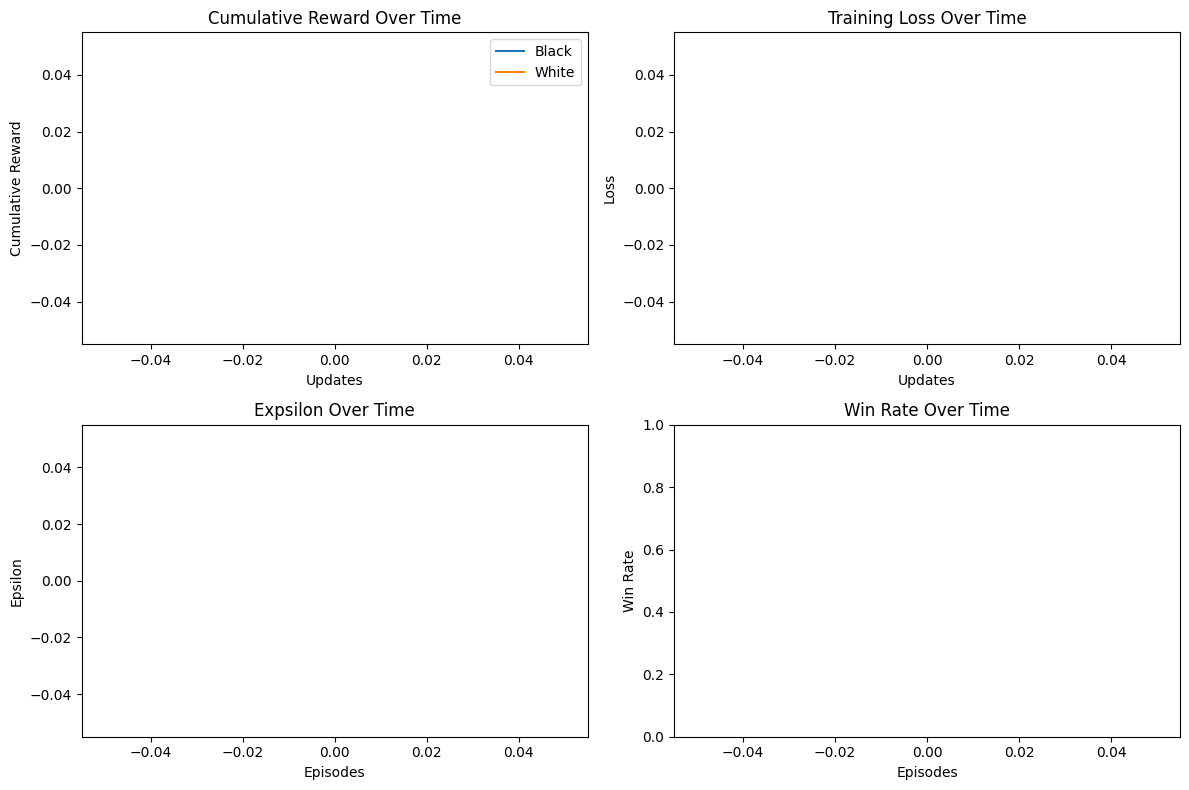

In [5]:
async def main():
    mcts = await MCTS.create(search_iterations=10)
    state = await mcts.gameserver.get_state()
    print(await mcts.search(state, False))


# Run the main coroutine
await main()

In [12]:
import torch
import torch.nn.functional as F

a = torch.tensor(
    [[8.0, 1.0, 4.0, 7.0]],
)

r1 = torch.softmax(a, dim=1)
r2 = F.log_softmax(a, dim=1)

r1, r2

(tensor([[7.2092e-01, 6.5740e-04, 1.3204e-02, 2.6521e-01]]),
 tensor([[-0.3272, -7.3272, -4.3272, -1.3272]]))

In [ ]:
[['.....', '.....', '..X..', '.....', '#....']]